In [1]:
import os
os.environ['RNETEB_PATH'] = '/home/users/gtully/RNET-EB'

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import ast
from torch.utils.data import Dataset, DataLoader
from ast import literal_eval
import sklearn
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import sys
import yaml

sys.path.append(os.environ['RNETEB_PATH']+ '/tools')
from plotting import *   # from RNETEB tools 
from testing import *   # from RNETEB tools

# RNET_EB_000_NPT Testing Important Notes

1) The test data is the filtered EternaBench Riboswitch Data that was not included in training (fasta files come from the EternaFold repository, and more info can be found in /data/RibonanzaNet_EB_data_prep.ipynb notebook. (From reading the description in the EternaFold paper and repository, these sequences were not used for training EternaFold). 

2) Even though a partition function calculation is not used to generate riboswitch affinities, the test prediction file is saved with the suffix "Z" so that the nonmenclature aligns with the EternaBench benchmarking scripts for evaluating predictions against the pre-computed affinities from other packages. 



## Set seed. 

In [3]:
# Set seed for reproducibility
SEED = 0

random.seed(SEED)

# NumPy
np.random.seed(SEED)

# torch 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # for multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Import Cleaned Test Data from RibonanzaNet_EB_data_prep.ipynb

In [4]:
test_df = pd.read_json(os.environ['RNETEB_PATH'] + '/data/processed_data/RNET_EB_test.json')

In [5]:
sys.path.append(os.environ['RNETEB_PATH']+'/ribonanzanet2d-final')

from Network import *

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config, pretrained=False):
        super(finetuned_RibonanzaNet, self).__init__(config)
        if pretrained:
            self.load_state_dict(torch.load(os.environ['RNETEB_PATH']+'/ribonanzanet-weights/RibonanzaNet.pt',map_location='cpu'))

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.decoder = nn.Linear(64, 2)  # From 64 "pooled values from each channel " to 2 output labels

    def forward(self,src):

        sequence_features, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))
        pairwise_features = pairwise_features.squeeze(0)  # Remove the batch dimension to make it [H, W, 64]
        pairwise_features = pairwise_features.permute(2, 0, 1)  # Change to [64, H, W] to match pooling expectation (C, H, W)

        # Apply global average pooling, result is [64, 1, 1]
        pairwise_features = self.global_pool(pairwise_features)

        # Flatten the output to [64]
        pairwise_features = pairwise_features.view(pairwise_features.size(0))  # Flatten to [64] (batch size 1, so this will be [64])

        # Pass through the decoder to get the final output [2]
        output = self.decoder(pairwise_features)

        return output

In [6]:
config=load_config_from_yaml(os.environ['RNETEB_PATH'] + "/ribonanzanet2d-final/configs/pairwise.yaml")
model=finetuned_RibonanzaNet(config,pretrained=False).cuda()



constructing 9 ConvTransformerEncoderLayers


### Save the epoch losses as well as weights and model check point. 
### Also save plots of training and validation losses. 

In [7]:
# Initialize loss function for computing test loss
criterion = torch.nn.L1Loss()

In [8]:
checkpoint_path = os.path.join(os.environ['RNETEB_PATH'], 
                               'results/checkpoints/RNETEB_000_NPT/RNET_EB_000_NPT_best_checkpoint.pt')

test_data_with_preds, test_loss, checkpoint_info = test_from_checkpoint(
    checkpoint_path=checkpoint_path,
    test_df=test_df,
    model=model,
    model_name='RNet_EB_000_NPT',
    criterion=criterion,
    batch_size=1,
    device='cuda',
    save_predictions=True,
    output_dir=os.path.join(os.environ['RNETEB_PATH'], 'results/test_preds')
)

# View predictions
print(test_data_with_preds.head())

Loading checkpoint from: /home/users/gtully/RNET-EB/results/checkpoints/RNETEB_000_NPT/RNET_EB_000_NPT_best_checkpoint.pt

Checkpoint Information:
  Epoch: 11
  Training Loss: 0.8318454272606793
  Validation Loss: 0.8373973951430692
  Best Loss: 0.8373973951430692

Running inference on test data...


Testing:   0%|          | 0/5341 [00:00<?, ?it/s]/home/users/gtully/.local/lib/python3.9/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/users/gtully/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Testing: 100%|██████████| 5341/5341 [02:32<00:00, 35.01it/s, loss=0.9569]



Average Test Loss: 0.9569

Processing predictions...

Predictions saved to: /home/users/gtully/RNET-EB/results/test_preds/RS_RNet_EB_000_NPT_Z.json

Testing Complete!
Total test samples: 5341

   level_0  Activation Ratio Design  Folding_Subscore  KDFMN      KDOFF  \
0        9          1.094796   None               NaN    NaN  10.505832   
1       10          0.976644   None               NaN    NaN   6.839630   
2       14          0.725943   None               NaN    NaN  12.469291   
3       21          1.039239   None               NaN    NaN  11.798062   
4       26          1.296336   None               NaN    NaN  20.589867   

        KDON  KDnoFMN     Kd_OFF      Kd_ON  ...  logkd_nolig logkd_lig  \
0   9.596158      NaN  10.505832   9.596158  ...     2.261363  2.351930   
1   7.003199      NaN   6.839630   7.003199  ...     1.946367  1.922734   
2  17.176675      NaN  12.469291  17.176675  ...     2.843552  2.523269   
3  11.352594      NaN  11.798062  11.352594  ...     2.

## Save figure showing correlation of predictions. 

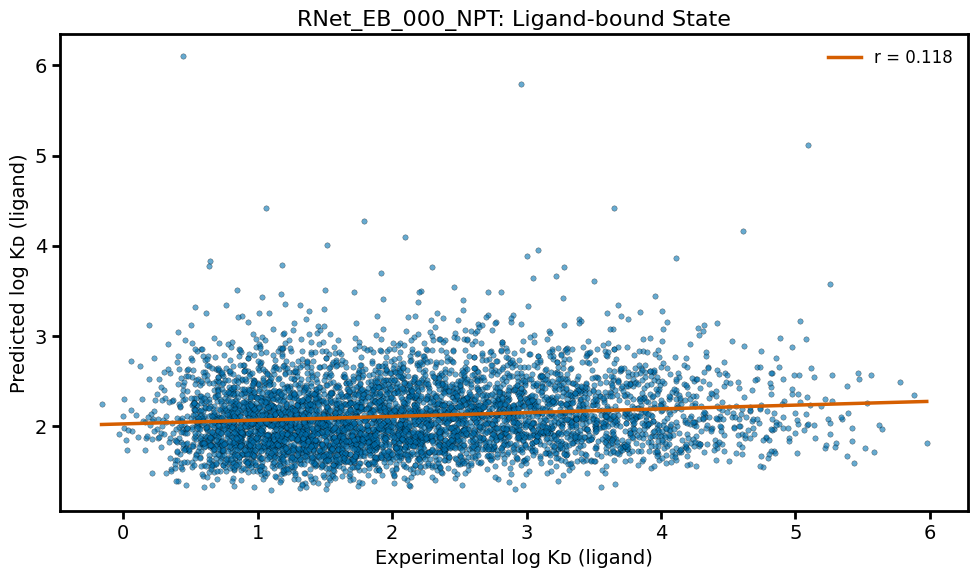

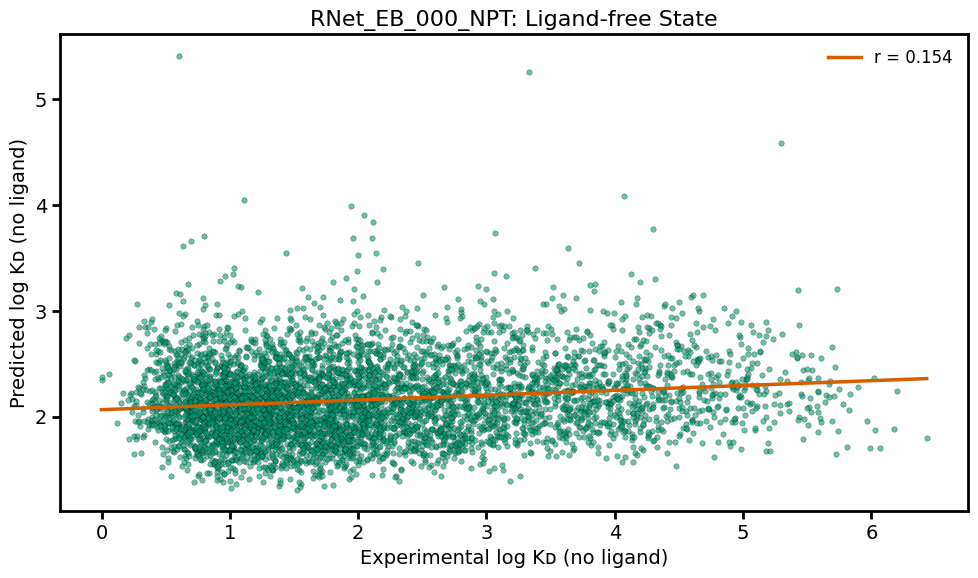

Ligand correlation: 0.118
No-ligand correlation: 0.154


In [13]:
correlations = plot_prediction_comparison(
    test_data_with_preds, model_name = 'RNet_EB_000_NPT',
    save_dir= os.environ['RNETEB_PATH'] + '/results/figures/RNETEB_000_NPT/test_pred_corr_plots',
    show_plots=True
)

print(f"Ligand correlation: {correlations['correlation_lig']:.3f}")
print(f"No-ligand correlation: {correlations['correlation_nolig']:.3f}")

## Double-check the saved test prediction dataframe 

In [10]:
test_preds_000 = pd.read_json(os.environ['RNETEB_PATH'] + '/results/test_preds/RS_RNet_EB_000_NPT_Z.json')

In [11]:
test_preds_000.head()

,level_0,Activation Ratio,Design,Folding_Subscore,KDFMN,KDOFF,KDON,KDnoFMN,Kd_OFF,Kd_ON,...,logkd_nolig,logkd_lig,logkd_nolig_scaled,logkd_lig_scaled,Dataset,passed_CDHIT_filter,log_AR,log_kfold_est_lig_Z_RNet_EB_000_NPT,log_kfold_est_nolig_Z_RNet_EB_000_NPT,test_loss
0,9,1.094796,None,NaN,NaN,10.505832,9.596158,NaN,10.505832,9.596158,...,2.261363,2.351930,1.160016,1.250584,Ribologic_FMN,True,0.090568,1.921196,1.934752,0.956893
1,10,0.976644,None,NaN,NaN,6.839630,7.003199,NaN,6.839630,7.003199,...,1.946367,1.922734,0.845021,0.821387,Ribologic_FMN,True,-0.023633,2.347510,2.381986,0.956893
2,14,0.725943,None,NaN,NaN,12.469291,17.176675,NaN,12.469291,17.176675,...,2.843552,2.523269,1.742206,1.421923,Ribologic_FMN,True,-0.320283,1.776424,1.899788,0.956893
3,21,1.039239,None,NaN,NaN,11.798062,11.352594,NaN,11.798062,11.352594,...,2.429446,2.467935,1.328100,1.366589,Ribologic_FMN,True,0.038489,2.185735,2.258106,0.956893
4,26,1.296336,None,NaN,NaN,20.589867,15.883128,NaN,20.589867,15.883128,...,2.765257,3.024799,1.663911,1.923453,Ribologic_FMN,True,0.259542,1.463420,1.555916,0.956893


In [12]:
len(test_preds_000)

5341